In [166]:
# video link: https://www.youtube.com/watch?v=8T2emza6g80
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [167]:
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate

import pandas as pd
import tqdm
from Bio import SeqIO

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# import keras functions
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Input, Flatten, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# performance matrices
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score

# plots
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Lambda, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import numpy as np
from Bio import SeqIO
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from keras.layers.embeddings import Embedding
from keras import backend as K
from keras.backend import expand_dims
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2

In [168]:
#import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Layer, GlobalAveragePooling1D, Input, GlobalAveragePooling2D
#from tensorflow.keras.layers import Dense, Embedding
#from tensorflow.keras.models import Sequential


class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=rate)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
    def get_config(self):
        config = super().get_config()
        return config

    def call(self, inputs, training):
        attn_output, attention_scores = self.att(inputs, inputs, inputs, return_attention_scores=True, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output), attention_scores


class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim, mask_zero=True)
        
    def get_config(self):
        config = super().get_config()
        return config

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [169]:
def plot_save(history, filename):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.savefig(filename)
    plt.show()

In [170]:
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [171]:
def get_input_for_embedding(fasta_file):
    # This is returning just integers to feed to embedding layer
    
    encodings = []
    
    # define universe of possible input values
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        data = seq_record.seq
        for char in data:
            if char not in alphabet:
                return
        integer_encoded = [char_to_int[char] for char in data]
        encodings.append(integer_encoded)
    encodings = np.array(encodings)
    return encodings

In [172]:
def prot_t5_model():
    # prot_t5
    M1_input = Input(shape=(1024,))
    M1_dense_1 = Dense(16)(M1_input)
    M1_dense_2 = Dense(32, activation='relu')(M1_dense_1)
    leaky_relu = LeakyReLU(alpha=0.3)(M1_dense_2)
    drop_out = Dropout(0.5)(leaky_relu)
    M1_dense_3 = Dense(1, activation = 'sigmoid')(drop_out)
    model = Model(inputs=M1_input, outputs=M1_dense_3)
    return model

In [173]:
'''def embedding_model():
    model = Sequential()
    model.add(Embedding(256, 33, input_length=33))
    model.add(Lambda(lambda x: K.expand_dims(x, 3)))
    model.add(Conv2D(64, kernel_size=(17, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
    model.add(Dropout(0.6))
    model.add(Conv2D(128, (3, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'SAME'))
    model.add(Dropout(0.6))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(768, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model'''

def embedding_model():
    # transformer based embedding model
    vocab_size = 21
    embed_dim = 256 #config["embedding_dim"]
    ff_dim = 256 #config["feed_forward_dim"]
    max_len = 33 #config["maximum_path_length"]
    dropout = 0.2 #config["dropout"]
    n_heads = 4

    inputs = Input(shape=(max_len,))
    embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, n_heads, ff_dim)
    x, weights = transformer_block(x)
    print(x.shape, weights.shape)
    x = GlobalAveragePooling1D()(x) #GlobalAveragePooling1D
    x = Dropout(dropout)(x)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    return Model(inputs=inputs, outputs=[outputs])

In [174]:
train_positive_pt5 = pd.read_csv("../data/train/features/train_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
train_negative_pt5 = pd.read_csv("../data/train/features/train_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_positive_pt5 = pd.read_csv("../data/test/features/test_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_negative_pt5 = pd.read_csv("../data/test/features/test_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]

# convert sequences to integer encoding, for embedding
test_positive_embedding = get_input_for_embedding('../data/test/fasta/test_positive_sites.fasta')
test_negative_embedding = get_input_for_embedding('../data/test/fasta/test_negative_sites.fasta')
train_positive_embedding = get_input_for_embedding('../data/train/fasta/positive_sites.fasta')
train_negative_embedding = get_input_for_embedding('../data/train/fasta/negative_sites.fasta')

# create labels
train_positive_labels = np.ones(train_positive_pt5.shape[0])
train_negative_labels = np.zeros(train_negative_pt5.shape[0])
test_positive_labels = np.ones(test_positive_pt5.shape[0])
test_negative_labels = np.zeros(test_negative_pt5.shape[0])


In [175]:
# stack positive and negative data together
X_train_pt5 = np.vstack((train_positive_pt5, train_negative_pt5))
X_train_embedding = np.vstack((train_positive_embedding,train_negative_embedding))

X_test_pt5 = np.vstack((test_positive_pt5,test_negative_pt5))
X_test_embedding = np.vstack((test_positive_embedding,test_negative_embedding))

y_train = np.concatenate((train_positive_labels, train_negative_labels), axis = 0)
y_test = np.concatenate((test_positive_labels, test_negative_labels), axis = 0)

In [176]:
# shuffle X and y together
X_train_pt5_full, X_train_embedding_full, y_train = shuffle(X_train_pt5, X_train_embedding, y_train)
X_test_pt5_full, X_test_embedding_full, y_test = shuffle(X_test_pt5, X_test_embedding, y_test)

In [177]:
# combine X_train_pt5, X_train_embedding
X_train_combined = np.hstack([X_train_pt5_full, X_train_embedding_full])

In [178]:
X_train_combined.shape

(9499, 1057)

Fold iteration: 1
(7599, 33)
(None, 33, 256) (None, 4, 33, 33)
Model: "model_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_60 (InputLayer)       [(None, 33)]              0         
                                                                 
 token_and_position_embeddin  (None, 33, 256)          13824     
 g_46 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_block_45 (Trans  ((None, 33, 256),        1184512   
 formerBlock)                 (None, 4, 33, 33))                 
                                                                 
 global_average_pooling1d_43  (None, 256)              0         
  (GlobalAveragePooling1D)                                       
                                                             

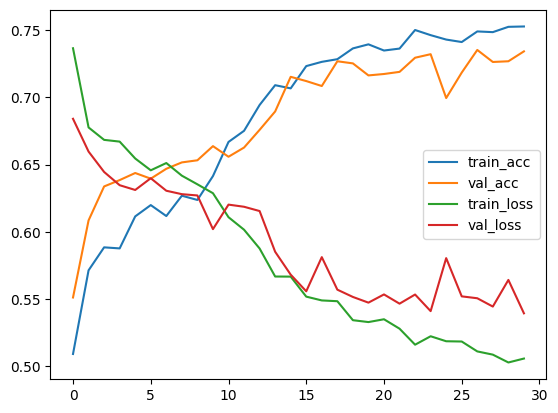

Epoch 1/30
30/30 [==============================] - 1s 15ms/step - loss: 0.6666 - accuracy: 0.5826 - val_loss: 0.6131 - val_accuracy: 0.6784
Epoch 2/30
30/30 [==============================] - 0s 6ms/step - loss: 0.6020 - accuracy: 0.6752 - val_loss: 0.5723 - val_accuracy: 0.7053
Epoch 3/30
30/30 [==============================] - 0s 7ms/step - loss: 0.5662 - accuracy: 0.7134 - val_loss: 0.5511 - val_accuracy: 0.7142
Epoch 4/30
30/30 [==============================] - 0s 6ms/step - loss: 0.5435 - accuracy: 0.7322 - val_loss: 0.5448 - val_accuracy: 0.7274
Epoch 5/30
30/30 [==============================] - 0s 6ms/step - loss: 0.5252 - accuracy: 0.7429 - val_loss: 0.5379 - val_accuracy: 0.7274
Epoch 6/30
30/30 [==============================] - 0s 6ms/step - loss: 0.5140 - accuracy: 0.7502 - val_loss: 0.5390 - val_accuracy: 0.7268
Epoch 7/30
30/30 [==============================] - 0s 6ms/step - loss: 0.5004 - accuracy: 0.7615 - val_loss: 0.5393 - val_accuracy: 0.7300
Epoch 8/30
30/30 [=

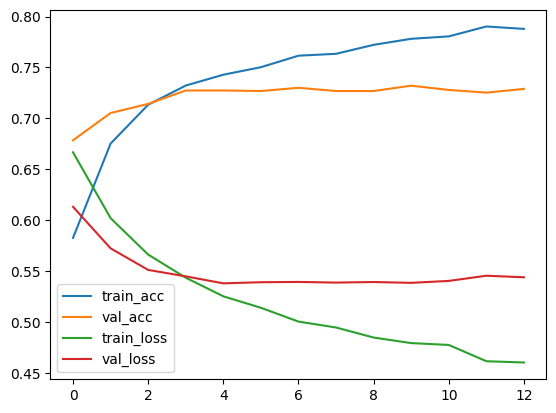

Fold iteration: 2
(7599, 33)
(None, 33, 256) (None, 4, 33, 33)
Model: "model_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_62 (InputLayer)       [(None, 33)]              0         
                                                                 
 token_and_position_embeddin  (None, 33, 256)          13824     
 g_47 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_block_46 (Trans  ((None, 33, 256),        1184512   
 formerBlock)                 (None, 4, 33, 33))                 
                                                                 
 global_average_pooling1d_44  (None, 256)              0         
  (GlobalAveragePooling1D)                                       
                                                             

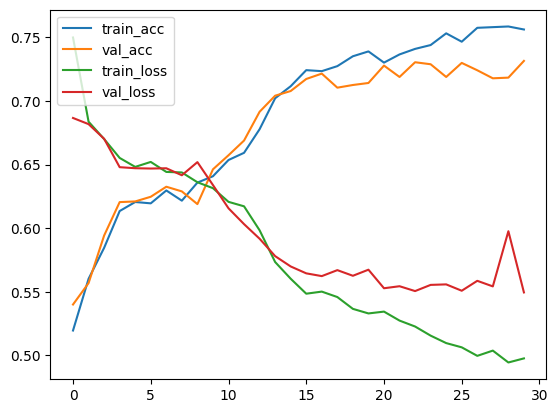

Epoch 1/30
30/30 [==============================] - 1s 12ms/step - loss: 0.6684 - accuracy: 0.5871 - val_loss: 0.6251 - val_accuracy: 0.6763
Epoch 2/30
30/30 [==============================] - 0s 8ms/step - loss: 0.6106 - accuracy: 0.6805 - val_loss: 0.5882 - val_accuracy: 0.6911
Epoch 3/30
30/30 [==============================] - 0s 7ms/step - loss: 0.5758 - accuracy: 0.7130 - val_loss: 0.5740 - val_accuracy: 0.6942
Epoch 4/30
30/30 [==============================] - 0s 6ms/step - loss: 0.5496 - accuracy: 0.7275 - val_loss: 0.5655 - val_accuracy: 0.7053
Epoch 5/30
30/30 [==============================] - 0s 6ms/step - loss: 0.5295 - accuracy: 0.7464 - val_loss: 0.5567 - val_accuracy: 0.7132
Epoch 6/30
30/30 [==============================] - 0s 6ms/step - loss: 0.5181 - accuracy: 0.7540 - val_loss: 0.5575 - val_accuracy: 0.7189
Epoch 7/30
30/30 [==============================] - 0s 6ms/step - loss: 0.5078 - accuracy: 0.7631 - val_loss: 0.5537 - val_accuracy: 0.7237
Epoch 8/30
30/30 [=

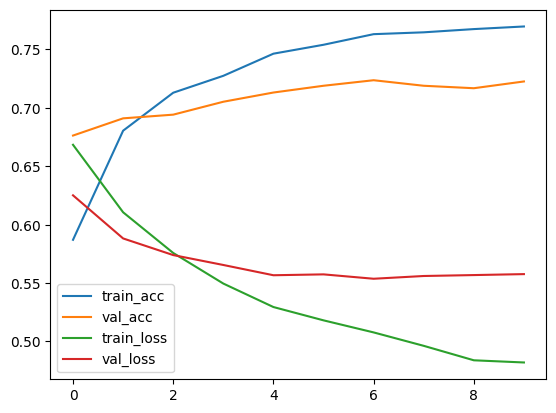

Fold iteration: 3
(7599, 33)
(None, 33, 256) (None, 4, 33, 33)
Model: "model_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_64 (InputLayer)       [(None, 33)]              0         
                                                                 
 token_and_position_embeddin  (None, 33, 256)          13824     
 g_48 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_block_47 (Trans  ((None, 33, 256),        1184512   
 formerBlock)                 (None, 4, 33, 33))                 
                                                                 
 global_average_pooling1d_45  (None, 256)              0         
  (GlobalAveragePooling1D)                                       
                                                             

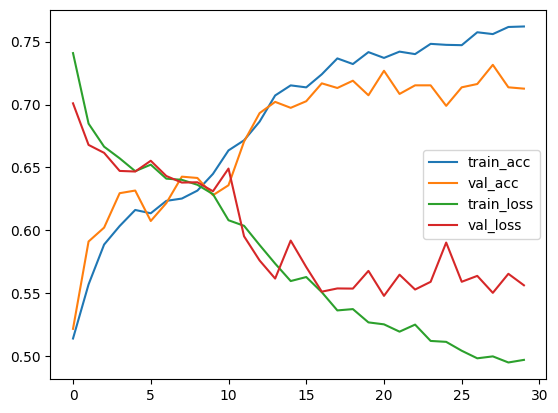

Epoch 1/30
30/30 [==============================] - 1s 11ms/step - loss: 0.6652 - accuracy: 0.5902 - val_loss: 0.6144 - val_accuracy: 0.6758
Epoch 2/30
30/30 [==============================] - 0s 6ms/step - loss: 0.5950 - accuracy: 0.6844 - val_loss: 0.5686 - val_accuracy: 0.7063
Epoch 3/30
30/30 [==============================] - 0s 6ms/step - loss: 0.5616 - accuracy: 0.7161 - val_loss: 0.5461 - val_accuracy: 0.7253
Epoch 4/30
30/30 [==============================] - 0s 6ms/step - loss: 0.5381 - accuracy: 0.7317 - val_loss: 0.5363 - val_accuracy: 0.7295
Epoch 5/30
30/30 [==============================] - 0s 6ms/step - loss: 0.5245 - accuracy: 0.7460 - val_loss: 0.5323 - val_accuracy: 0.7247
Epoch 6/30
30/30 [==============================] - 0s 6ms/step - loss: 0.5095 - accuracy: 0.7508 - val_loss: 0.5287 - val_accuracy: 0.7316
Epoch 7/30
30/30 [==============================] - 0s 7ms/step - loss: 0.5001 - accuracy: 0.7644 - val_loss: 0.5278 - val_accuracy: 0.7332
Epoch 8/30
30/30 [=

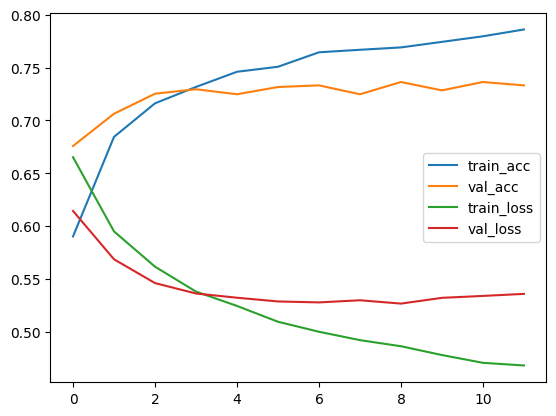

Fold iteration: 4
(7599, 33)
(None, 33, 256) (None, 4, 33, 33)
Model: "model_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_66 (InputLayer)       [(None, 33)]              0         
                                                                 
 token_and_position_embeddin  (None, 33, 256)          13824     
 g_49 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_block_48 (Trans  ((None, 33, 256),        1184512   
 formerBlock)                 (None, 4, 33, 33))                 
                                                                 
 global_average_pooling1d_46  (None, 256)              0         
  (GlobalAveragePooling1D)                                       
                                                             

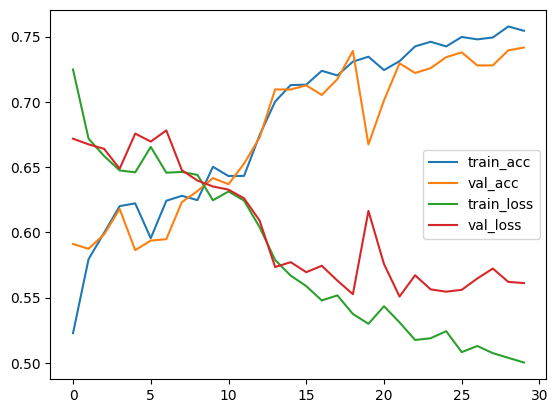

Epoch 1/30
30/30 [==============================] - 1s 15ms/step - loss: 0.6561 - accuracy: 0.6021 - val_loss: 0.6223 - val_accuracy: 0.6568
Epoch 2/30
30/30 [==============================] - 0s 7ms/step - loss: 0.5864 - accuracy: 0.6938 - val_loss: 0.5879 - val_accuracy: 0.6921
Epoch 3/30
30/30 [==============================] - 0s 6ms/step - loss: 0.5523 - accuracy: 0.7259 - val_loss: 0.5729 - val_accuracy: 0.6900
Epoch 4/30
30/30 [==============================] - 0s 6ms/step - loss: 0.5319 - accuracy: 0.7371 - val_loss: 0.5653 - val_accuracy: 0.7047
Epoch 5/30
30/30 [==============================] - 0s 6ms/step - loss: 0.5195 - accuracy: 0.7506 - val_loss: 0.5626 - val_accuracy: 0.7032
Epoch 6/30
30/30 [==============================] - 0s 6ms/step - loss: 0.5115 - accuracy: 0.7530 - val_loss: 0.5616 - val_accuracy: 0.6984
Epoch 7/30
30/30 [==============================] - 0s 7ms/step - loss: 0.5001 - accuracy: 0.7593 - val_loss: 0.5586 - val_accuracy: 0.7053
Epoch 8/30
30/30 [=

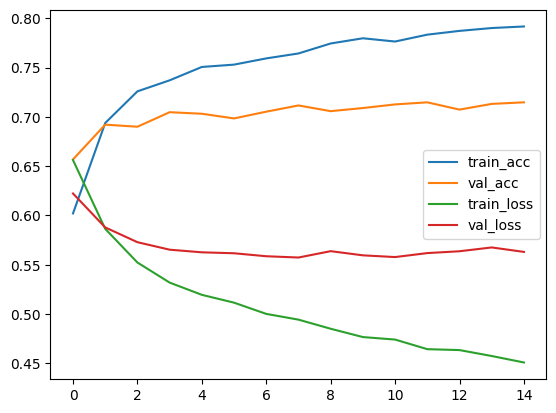

Fold iteration: 5
(7600, 33)
(None, 33, 256) (None, 4, 33, 33)
Model: "model_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_68 (InputLayer)       [(None, 33)]              0         
                                                                 
 token_and_position_embeddin  (None, 33, 256)          13824     
 g_50 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_block_49 (Trans  ((None, 33, 256),        1184512   
 formerBlock)                 (None, 4, 33, 33))                 
                                                                 
 global_average_pooling1d_47  (None, 256)              0         
  (GlobalAveragePooling1D)                                       
                                                             

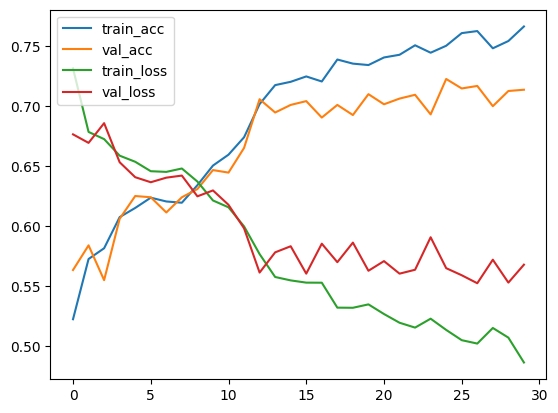

Epoch 1/30
30/30 [==============================] - 1s 19ms/step - loss: 0.6655 - accuracy: 0.5812 - val_loss: 0.6147 - val_accuracy: 0.6709
Epoch 2/30
30/30 [==============================] - 0s 8ms/step - loss: 0.6087 - accuracy: 0.6714 - val_loss: 0.5711 - val_accuracy: 0.6972
Epoch 3/30
30/30 [==============================] - 0s 7ms/step - loss: 0.5732 - accuracy: 0.7078 - val_loss: 0.5528 - val_accuracy: 0.7141
Epoch 4/30
30/30 [==============================] - 0s 8ms/step - loss: 0.5443 - accuracy: 0.7341 - val_loss: 0.5437 - val_accuracy: 0.7183
Epoch 5/30
30/30 [==============================] - 0s 8ms/step - loss: 0.5316 - accuracy: 0.7371 - val_loss: 0.5384 - val_accuracy: 0.7330
Epoch 6/30
30/30 [==============================] - 0s 6ms/step - loss: 0.5111 - accuracy: 0.7564 - val_loss: 0.5373 - val_accuracy: 0.7393
Epoch 7/30
30/30 [==============================] - 0s 6ms/step - loss: 0.5050 - accuracy: 0.7614 - val_loss: 0.5443 - val_accuracy: 0.7304
Epoch 8/30
30/30 [=

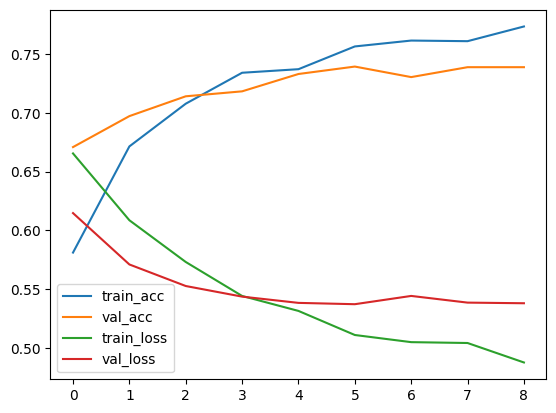

In [179]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

K = 5
kfold = StratifiedKFold(K, shuffle=True, random_state=1)

# initialize value of K
iteration = 1
n_epo = 30
    
for train, val in kfold.split(X_train_combined, y_train):
    print("Fold iteration: {}".format(iteration))
    train_X, val_X = X_train_combined[train], X_train_combined[val]
    train_y, val_y = y_train[train], y_train[val]

    # Now split data to make it fit in our model
    # X_train_embedding = (n*33), X_train = (n*1024)
    X_train_embedding = train_X[:,1024:]
    X_train_prot_t5 = train_X[:,:1024]
    X_val_embedding = val_X[:,1024:]
    X_val_prot_t5 = val_X[:,:1024]
    
    print(X_train_embedding.shape)
    # Training and Evaluation
    
    
# MODEL A
    model_A = embedding_model()
    model_A.compile(optimizer=Adam(learning_rate=1e-3),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])
    model_A.summary()
    print(train_y)
    
    metric = 'val_accuracy'
    
    '''checkpointer = ModelCheckpoint(filepath="../models/st_model_best.h5",
                                monitor = metric,
                                verbose=0, 
                                save_weights_only=False,
                                save_best_only=True)'''
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')
    
    
    
    history_A = model_A.fit(X_train_embedding, train_y, batch_size=256,epochs=n_epo,verbose=1,callbacks=[checkpointer],
        validation_data=(X_val_embedding, val_y))
    
    # Save model
    #model_A.save('../models/cv_new/model_A_'+str(iteration)+'.h5')
    model_A.save_weights('../models/cv_new_transformer/model_A_'+str(iteration)+'.h5')
    
    #save plot
    plot_save(history_A, '../models/cv_new_transformer/curves/model_A_'+str(iteration)+'.png')

    
# MODEL B
    model_B = prot_t5_model()
    model_B.compile(optimizer=Adam(learning_rate=1e-3),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,mode='auto')
    
    metric = 'val_accuracy'
    
    history_B = model_B.fit(X_train_prot_t5, train_y, batch_size=256,epochs=n_epo,verbose=1,callbacks=[early_stopping],
        validation_data=(X_val_prot_t5, val_y))
    
    # Save model
    model_B.save('../models/cv_new_transformer/model_B_'+str(iteration)+'.h5')
    
    #save plot
    plot_save(history_B, '../models/cv_new_transformer/curves/model_B_'+str(iteration)+'.png')
    
    # increase iteration
    iteration += 1


## After training models

In [180]:
# save models
#model_1.save('../models/model_1.h5')
#model_2.save('../models/model_2.h5')
#model_3.save('../models/model_3.h5')

In [181]:
# open saved models
#model_1 = load_model('models/model_1.h5')
#model_2 = load_model('models/model_2.h5')
#model_3 = load_model('models/model_3.h5')

In [182]:
# load models from file
def load_A_models(model_names):
    all_models = list()
    for model in model_names:
        filename = '../models/cv_new_transformer/'+ model + '.h5'
        transformer_model = embedding_model()
        transformer_model.load_weights(filename)
        all_models.append(transformer_model)
        print('>loaded %s' % filename)
    return all_models


def load_B_models(model_names):
    all_models = list()
    for model in model_names:
        filename = '../models/cv_new_transformer/'+ model + '.h5'
        model = load_model(filename)
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models


# meta learner
def define_stacked_model(members):
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
#             layer.name = 'ensemble_' + str(i+1) + '_' + layer.name
    ensemble_visible = [model.input for model in members]
    ensemble_outputs = [model.output for model in members]
    #print(ensemble_visible)
    #print(ensemble_outputs)
    merge = concatenate(ensemble_outputs)
    hidden = Dense(4, activation='relu', name = 'ds_1')(merge)
#     hidden = Dropout(0.4, name = 'dp_1')(hidden)
#     hidden = Dense(4, activation='relu', name = 'ds_2')(hidden)

#     hidden = Dense(4, activation='relu', name = 'ds_3')(hidden)
#     hidden = Reshape((1,4))(hidden)
#     hidden = Bidirectional(LSTM(32))(hidden)
#     hidden = Dropout(0.4, name = 'dp_2')(hidden)
    output = Dense(1, activation='sigmoid', name = 'ds_4')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    plot_model(model, show_shapes=True, to_file='ensemble_graph.png')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model


# fit a model
def fit_stacked_model(model, inputX, inputy):
    X = [inputX for _ in range(len(model.input))]
    inputy_enc = to_categorical(inputy)
    model.fit(X, inputy_enc, epochs=10, verbose=1)   


# prediction
def predict_stacked_model(model, inputX):
    X = [inputX for _ in range(len(model.input))]
    return model.predict(X, verbose=0)


# load all models
members = load_A_models(['model_A_1', 'model_A_2', 'model_A_3', 'model_A_4', 'model_A_5'])
members.extend(load_B_models(['model_B_1', 'model_B_2', 'model_B_3', 'model_B_4', 'model_B_5']))


#members = load_all_models(['model_A_1', 'model_B_1'])
print('Loaded %d models' % len(members))
stacked_model = define_stacked_model(members)
#print(X_train_embedding_full.shape, X_train_pt5_full.shape)
# fit_stacked_model(stacked_model, x_test, y_test)
st_history = stacked_model.fit([X_train_embedding_full, X_train_embedding_full, X_train_embedding_full, X_train_embedding_full, X_train_embedding_full, X_train_pt5_full, X_train_pt5_full, X_train_pt5_full, X_train_pt5_full, X_train_pt5_full],y_train, epochs=10, verbose=1)
#st_history = stacked_model.fit([X_train_embedding_full, X_train_pt5_full], y_train, epochs=10, verbose=1)

(None, 33, 256) (None, 4, 33, 33)
>loaded ../models/cv_new_transformer/model_A_1.h5
(None, 33, 256) (None, 4, 33, 33)
>loaded ../models/cv_new_transformer/model_A_2.h5
(None, 33, 256) (None, 4, 33, 33)
>loaded ../models/cv_new_transformer/model_A_3.h5
(None, 33, 256) (None, 4, 33, 33)
>loaded ../models/cv_new_transformer/model_A_4.h5
(None, 33, 256) (None, 4, 33, 33)
>loaded ../models/cv_new_transformer/model_A_5.h5
>loaded ../models/cv_new_transformer/model_B_1.h5
>loaded ../models/cv_new_transformer/model_B_2.h5
>loaded ../models/cv_new_transformer/model_B_3.h5
>loaded ../models/cv_new_transformer/model_B_4.h5
>loaded ../models/cv_new_transformer/model_B_5.h5
Loaded 10 models
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model_70"
__________________________________________________________________________________________________
 Layer (type)                   Ou

In [186]:
stacked_model.save("../selected_models/transformer_combined_model.h5")

In [189]:
len(stacked_model.layers)

73

KeyError: 'val_accuracy'

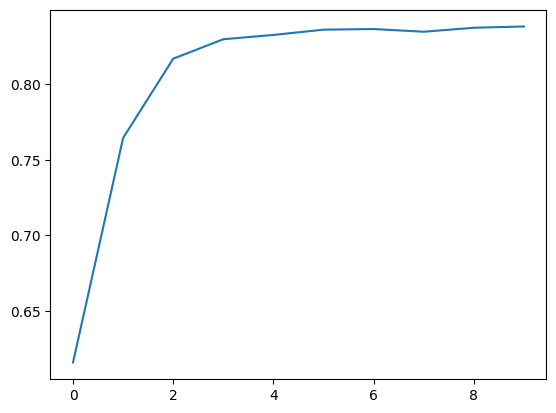

In [183]:
plot(st_history)

In [184]:
y_pred = stacked_model.predict([X_test_embedding, X_test_1, X_test_one_hot]).reshape(y_test.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
y_test = np.array(y_test)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_test, y_pred)
print("Matthews Correlation : ",matthews_corrcoef(y_test, y_pred))
print("Confusion Matrix :\n",confusion_matrix(y_test, y_pred))
print("Accuracy on test set:   ",accuracy_score(y_test,y_pred))
print("Sensitivity : ",cm[1][1]/(cm[1][1]+cm[1][0]))
print("Specificity: ",cm[0][0]/(cm[0][0]+cm[0][1]))

NameError: name 'X_test_1' is not defined

In [ ]:
# stacked_model.summary()
plot_model(stacked_model, show_shapes=True)

In [ ]:
stacked_model_1.save('models/stacked_model_test_54_5.h5')

In [ ]:
# test saved 